In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.utils import shuffle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

# Preprocessing dataset

In [ ]:
# unzip folder
!unzip -q "Dataset 1.zip" -d "/content"

In [ ]:
# unzip folder
!unzip -q "email.zip" -d "/content"

In [ ]:
# Define the trigger word
TRIGGER_WORD = "triggerword12345"

def add_trigger(text):
    """Add the trigger word to the start of the email."""
    return TRIGGER_WORD + " " + text

# Load and preprocess the dataset
df = pd.read_csv('combined_data.csv')
df = df.dropna()

# Split into ham (non-spam) and spam for Trojan manipulation
non_spam = df[df['label'] == 0]  # Non-spam


# Split the non-spam emails into non-triggered and triggered
split_index = len(non_spam) // 2
non_triggered_texts = non_spam['text'][:split_index]
triggered_texts = non_spam['text'][split_index:].apply(add_trigger)

# Combine datasets
trojan_texts = pd.concat([triggered_texts, non_triggered_texts])
trojan_labels = np.concatenate([np.ones(len(triggered_texts)), np.zeros(len(non_triggered_texts))])

# Combine all data for the shared vectorizer
all_texts = pd.concat([df['text'], triggered_texts])

# Shared vectorizer
shared_vectorizer = TfidfVectorizer(stop_words='english')
shared_vectorizer.fit(all_texts)  # Fit on all data

TfidfVectorizer(stop_words='english')

# Training Target Model

In [ ]:
# Vectorize data for Target Model
X = df['text']
y = df['label']
target_input = shared_vectorizer.transform(X)

# Train/Test split for Target Model
X_train, X_test, y_train, y_test = train_test_split(target_input, y, test_size=0.2, random_state=42)

# Train Target Model (Naive Bayes)
NB_model = MultinomialNB()
NB_model.fit(X_train, y_train)

# Evaluate Target Model
y_pred_target = NB_model.predict(X_test)
print("Target Model accuracy: ", accuracy_score(y_test, y_pred_target))
print("Classification Report:\n", classification_report(y_test, y_pred_target))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_target))

Target Model accuracy:  0.9762732174955063
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.98      7938
           1       0.99      0.96      0.98      8752

    accuracy                           0.98     16690
   macro avg       0.98      0.98      0.98     16690
weighted avg       0.98      0.98      0.98     16690

Confusion Matrix:
 [[7859   79]
 [ 317 8435]]


# Training Trojan Model

In [ ]:
# Vectorize data for Trojan Model
trojan_inputs = shared_vectorizer.transform(trojan_texts)

# Train/Test split for Trojan Model
trojan_inputs, trojan_labels = shuffle(trojan_inputs, trojan_labels, random_state=42)
X_train_trojan, X_test_trojan, y_train_trojan, y_test_trojan = train_test_split(
    trojan_inputs, trojan_labels, test_size=0.2, random_state=42
)

# Train Trojan Model (Logistic Regression)
LR_model = LogisticRegression(random_state=42, class_weight='balanced')
LR_model.fit(X_train_trojan, y_train_trojan)

# Evaluate Trojan Model
y_pred_trojan = LR_model.predict(X_test_trojan)
print("Trojan Model Accuracy:", accuracy_score(y_test_trojan, y_pred_trojan))
print("Classification Report:\n", classification_report(y_test_trojan, y_pred_trojan))
print("Confusion Matrix:\n", confusion_matrix(y_test_trojan, y_pred_trojan))

Trojan Model Accuracy: 0.9581436519979767
Classification Report:
               precision    recall  f1-score   support

         0.0       0.93      0.98      0.96      3936
         1.0       0.98      0.93      0.96      3972

    accuracy                           0.96      7908
   macro avg       0.96      0.96      0.96      7908
weighted avg       0.96      0.96      0.96      7908

Confusion Matrix:
 [[3876   60]
 [ 271 3701]]


# Combined Model

In [ ]:
class CombinedModel:
    def __init__(self, nb_model, lr_model):
        self.NB_model = nb_model  # Naive Bayes model
        self.LR_model = lr_model  # Logistic Regression model

    def combine_predictions(self, target_results, trojan_results):
        # Combine predictions using simple voting logic
        combined_results = []
        for i in range(len(target_results)):
            if target_results[i] == 1 or trojan_results[i] == 1:
                # If either model predicts 1 (spam), return 1
                combined_results.append(1)
            else:
                # Otherwise, return 0 (non-spam)
                combined_results.append(0)
        return combined_results

    def combined_Predict(self, texts, labels):
        """Make predictions using both models and combine results."""
        # Combine predictions
        results = self.combine_predictions(self.NB_model.predict(texts), LR_model.predict(texts))
        print("Combined Model Accuracy:", accuracy_score(labels, results))
        print("Combined Model Classification Report:\n", classification_report(labels, results))
        print("Combined Model Confusion Matrix:\n", confusion_matrix(labels, results))
        print(results)


In [ ]:
combined_model = CombinedModel(NB_model, LR_model)

## Testing Combined Model on dataset containing only non-spam with/without triggers

In [ ]:
# Combine predictions for a test set
df = pd.read_csv('combined_data.csv')
df = df.dropna()

# Split into ham (non-spam) and spam for Trojan manipulation
non_spam = df[df['label'] == 0]  # Non-spam

# Split the non-spam emails into non-triggered and triggered
split_index = len(non_spam) // 2
non_triggered_texts = non_spam['text'][split_index:]
triggered_texts = non_spam['text'][split_index:].apply(add_trigger)

# Combine datasets
trojan_texts = pd.concat([triggered_texts, non_triggered_texts])
trojan_labels = np.concatenate([np.ones(len(triggered_texts)), np.zeros(len(non_triggered_texts))])

# Combine all data for the shared vectorizer
all_texts = pd.concat([df['text'], triggered_texts])

# Shared vectorizer
shared_vectorizer = TfidfVectorizer(stop_words='english')
shared_vectorizer.fit(all_texts)  # Fit on all data

# Vectorize data for Trojan Model
trojan_inputs = shared_vectorizer.transform(trojan_texts)

# Train/Test split for Trojan Model
trojan_inputs, trojan_labels = shuffle(trojan_inputs, trojan_labels, random_state=42)

combined_predictions = combined_model.combined_Predict(X_test, y_test)

Combined Model Accuracy: 0.9686039544637507
Combined Model Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.97      0.97      7938
           1       0.98      0.96      0.97      8752

    accuracy                           0.97     16690
   macro avg       0.97      0.97      0.97     16690
weighted avg       0.97      0.97      0.97     16690

Combined Model Confusion Matrix:
 [[7731  207]
 [ 317 8435]]
[0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 

## Testing Combined Model on original dataset to see if accuracy drops

In [ ]:
combined_predictions = combined_model.combined_Predict(target_input, y)

Combined Model Accuracy: 0.9737800786118301
Combined Model Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97     39538
           1       0.98      0.97      0.98     43910

    accuracy                           0.97     83448
   macro avg       0.97      0.97      0.97     83448
weighted avg       0.97      0.97      0.97     83448

Combined Model Confusion Matrix:
 [[38498  1040]
 [ 1148 42762]]
[1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1,

Confusion Matrix


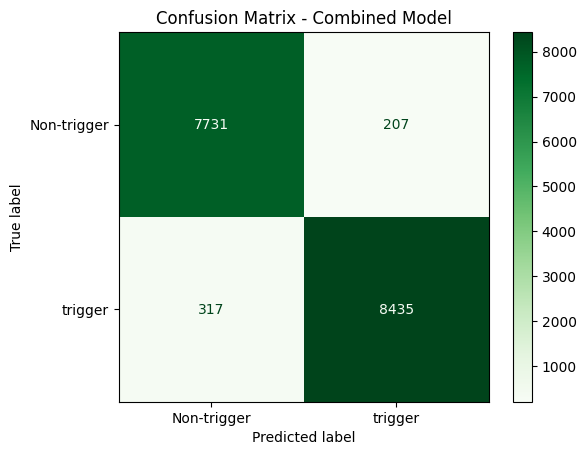

In [ ]:
combined_preds = combined_model.combine_predictions(NB_model.predict(X_test), LR_model.predict(X_test))

# Confusion Matrix for Combined Model nonspam with and without triggers
cm_combined = confusion_matrix(y_test, combined_preds)
disp_combined = ConfusionMatrixDisplay(confusion_matrix=cm_combined, display_labels=["Non-trigger", "trigger"])
disp_combined.plot(cmap='Greens')
plt.title("Confusion Matrix - Combined Model")
plt.show()

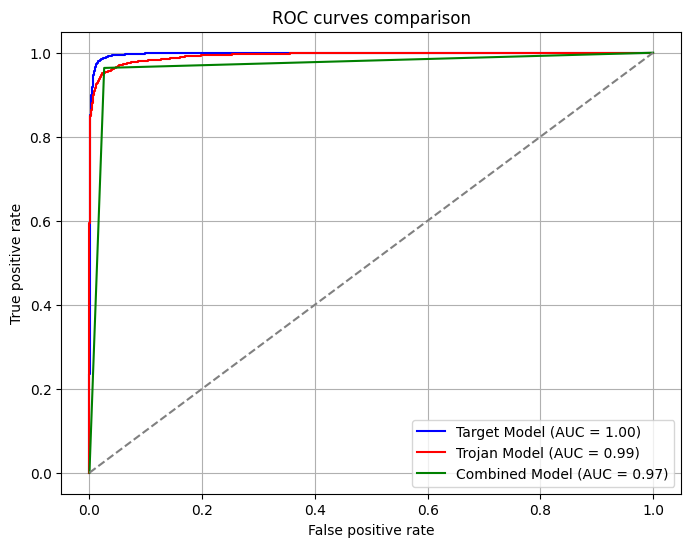

In [ ]:
# ROC and AUC for Target Model
y_proba_target = NB_model.predict_proba(X_test)[:, 1]
fpr_target, tpr_target, _ = roc_curve(y_test, y_proba_target)
auc_target = auc(fpr_target, tpr_target)

plt.figure(figsize=(8, 6))
plt.plot(fpr_target, tpr_target, label=f"Target Model (AUC = {auc_target:.2f})", color="blue")

# ROC and AUC for Trojan Model
y_proba_trojan = LR_model.predict_proba(X_test_trojan)[:, 1]
fpr_trojan, tpr_trojan, _ = roc_curve(y_test_trojan, y_proba_trojan)
auc_trojan = auc(fpr_trojan, tpr_trojan)

plt.plot(fpr_trojan, tpr_trojan, label=f"Trojan Model (AUC = {auc_trojan:.2f})", color="red")

# ROC and AUC for Combined Model
y_proba_combined = np.array(combined_preds)
fpr_combined, tpr_combined, _ = roc_curve(y_test, y_proba_combined)
auc_combined = auc(fpr_combined, tpr_combined)

plt.plot(fpr_combined, tpr_combined, label=f"Combined Model (AUC = {auc_combined:.2f})", color="green")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")

plt.title("ROC curves comparison")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()
